In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd
from matplotlib import gridspec
from scipy import stats
from sklearn import preprocessing

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Using TensorFlow backend.
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bpnachma

In [3]:
datafile="GD1-circle-140-30-15.pkl"
gaiadata=np.load(datafile,allow_pickle=True)
gaiadata2=np.array(gaiadata[['pmdec','pmra','dec','ra','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag']].astype('float32'))
gaiadata2 = np.vstack([gaiadata2[:,0].T,
           gaiadata2[:,1].T,
           gaiadata2[:,2].T,
           gaiadata2[:,3].T,
           (gaiadata2[:,5]-gaiadata2[:,6]).T,
           gaiadata2[:,4].T]).T
gaiadata2 = gaiadata2[np.sum(np.isnan(gaiadata2),axis=1)==0]
#if(dataset=='jhelum' or dataset=='weird'):
#    gaiadata2[:,3]=gaiadata2[:,3]-360*(gaiadata2[:,3]//180)
# Just use radius 15 circle
center_dec=0.5*(np.max(gaiadata2[:,2])+np.min(gaiadata2[:,2]))
center_ra=0.5*(np.max(gaiadata2[:,3])+np.min(gaiadata2[:,3]))
radius=np.sqrt((gaiadata2[:,2]-center_dec)**2+(gaiadata2[:,3]-center_ra)**2)
gaiadata2=gaiadata2[radius<15]
np.random.shuffle(gaiadata2)

In [4]:
gaiadata3=np.array(gaiadata[gaiadata['streammask']==1][['pmdec','pmra','dec','ra','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag']].astype('float32'))
gaiadata3 = np.vstack([gaiadata3[:,0].T,
           gaiadata3[:,1].T,
           gaiadata3[:,2].T,
           gaiadata3[:,3].T,
           (gaiadata3[:,5]-gaiadata3[:,6]).T,
           gaiadata3[:,4].T]).T
gaiadata3 = gaiadata3[np.sum(np.isnan(gaiadata3),axis=1)==0]
#if(dataset=='jhelum' or dataset=='weird'):
#    gaiadata2[:,3]=gaiadata2[:,3]-360*(gaiadata2[:,3]//180)
# Just use radius 15 circle
#center_dec=0.5*(np.max(gaiadata3[:,2])+np.min(gaiadata3[:,2]))
#center_ra=0.5*(np.max(gaiadata3[:,3])+np.min(gaiadata3[:,3]))
radius=np.sqrt((gaiadata3[:,2]-center_dec)**2+(gaiadata3[:,3]-center_ra)**2)
gaiadata3=gaiadata3[radius<15]
np.random.shuffle(gaiadata3)

In [5]:
gaiadata.keys()

Index(['source_id', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec',
       'pmdec_error', 'phot_g_mean_mag', 'phot_bp_mean_mag',
       'phot_rp_mean_mag', 'bp_rp', 'radial_velocity', 'radial_velocity_error',
       'teff_val', 'streammask'],
      dtype='object')

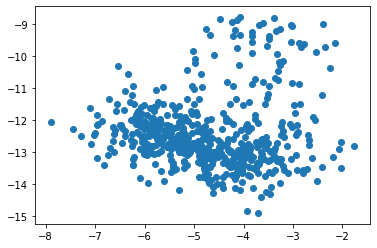

In [6]:
plt.scatter(gaiadata3[:,1],gaiadata3[:,0])

Text(0, 0.5, '$\\mu_\\delta$ [$\\mu$as/year]')

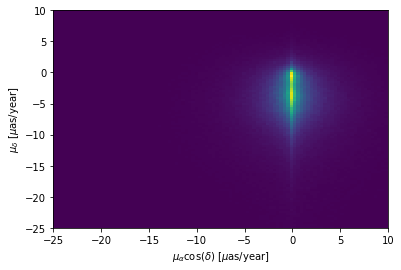

In [7]:
_,_,_,_=plt.hist2d(gaiadata2[:,1]*np.cos(gaiadata2[:,2]),gaiadata2[:,0],bins=[np.linspace(-25,10,100),np.linspace(-25,10,100)])
plt.xlabel(r"$\mu_\alpha\cos(\delta)$ [$\mu$as/year]")
plt.ylabel(r"$\mu_\delta$ [$\mu$as/year]")

Text(0, 0.5, '$\\delta$ [degrees]')

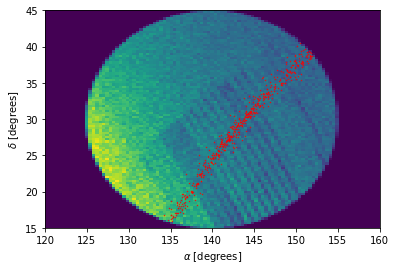

In [8]:
_,_,_,_=plt.hist2d(gaiadata2[:,3],gaiadata2[:,2],bins=[np.linspace(120,160,100),np.linspace(15,45,100)])
plt.scatter(gaiadata3[:,3],gaiadata3[:,2],color='red',s=0.2)
plt.xlabel(r"$\alpha$ [degrees]")
plt.ylabel(r"$\delta$ [degrees]")

Text(0, 0.5, '$\\delta$ [degrees]')

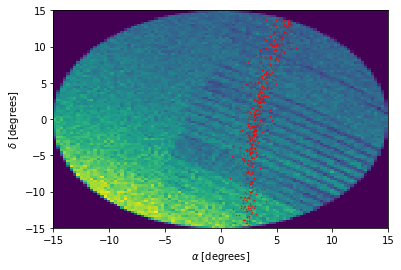

In [9]:
X = gaiadata2[:,3]-center_ra
Y = gaiadata2[:,2]-center_dec

Xs = gaiadata3[:,3]-center_ra
Ys = gaiadata3[:,2]-center_dec

theta = -0.5
Xr = X*np.cos(theta) + Y*np.sin(theta)
Yr = -X*np.sin(theta) + Y*np.cos(theta)
Xsr = Xs*np.cos(theta) + Ys*np.sin(theta)
Ysr = -Xs*np.sin(theta) + Ys*np.cos(theta)

_,_,_,_=plt.hist2d(Xr,Yr,bins=[np.linspace(-15,15,100),np.linspace(-15,15,100)])
plt.scatter(Xsr,Ysr,color='red',s=0.2)
plt.xlabel(r"$\alpha$ [degrees]")
plt.ylabel(r"$\delta$ [degrees]")

Text(0.5, 0, 'Rotated $\\delta$-$\\alpha$ space')

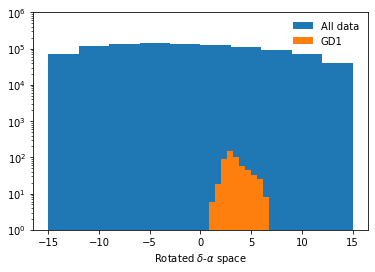

In [10]:
plt.hist(Xr,label="All data")
plt.hist(Xsr,label="GD1")
plt.yscale("log")
plt.legend(frameon=False)
plt.ylim([1,1e6])
plt.xlabel(r"Rotated $\delta$-$\alpha$ space")

Text(0.5, 0, '$\\mu_\\alpha\\cos(\\delta)$ [$\\mu$as/year]')

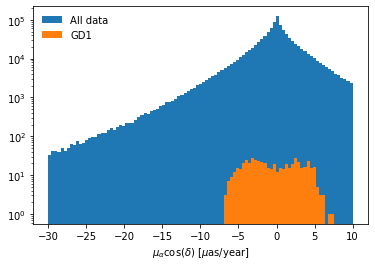

In [11]:
_,_,_=plt.hist(gaiadata2[:,1]*np.cos(gaiadata2[:,2]),bins=np.linspace(-30,10,100),label="All data")
_,_,_=plt.hist(gaiadata3[:,1]*np.cos(gaiadata3[:,2]),bins=np.linspace(-30,10,100),label="GD1")
plt.legend(frameon=False)
plt.yscale("log")
plt.xlabel(r"$\mu_\alpha\cos(\delta)$ [$\mu$as/year]")

Text(0.5, 0, '$\\mu_\\delta$ [$\\mu$as/year]')

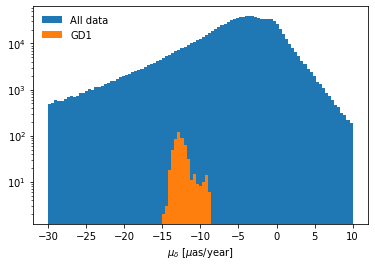

In [12]:
_,_,_=plt.hist(gaiadata2[:,0],bins=np.linspace(-30,10,100),label="All data")
_,_,_=plt.hist(gaiadata3[:,0],bins=np.linspace(-30,10,100),label="GD1")
plt.legend(frameon=False)
plt.yscale("log")
plt.xlabel(r"$\mu_\delta$ [$\mu$as/year]")

In [13]:
SR = gaiadata2[(gaiadata2[:,0] > -15)*(gaiadata2[:,0] < -11)]
SB = gaiadata2[(gaiadata2[:,0] > -18)*(gaiadata2[:,0] < -15)+(gaiadata2[:,0] > -11)*(gaiadata2[:,0] < -9.5)]
GD1 = gaiadata3

X = SR[:,3]-center_ra
Y = SR[:,2]-center_dec

theta = -0.5
Xr = X*np.cos(theta) + Y*np.sin(theta)
Yr = -X*np.sin(theta) + Y*np.cos(theta)

Xb = SB[:,3]-center_ra
Yb = SB[:,2]-center_dec

Xbr = Xb*np.cos(theta) + Yb*np.sin(theta)
Ybr = -Xb*np.sin(theta) + Yb*np.cos(theta)

Xs = GD1[:,3]-center_ra
Ys = GD1[:,2]-center_dec

Xsr = Xs*np.cos(theta) + Ys*np.sin(theta)
Ysr = -Xs*np.sin(theta) + Ys*np.cos(theta)

SR = np.c_[SR[:,0],Xr,SR[:,4],SR[:,5]]
SB = np.c_[SB[:,0],Xbr,SB[:,4],SB[:,5]]
GD1 = np.c_[GD1[:,0],Xsr,GD1[:,4],GD1[:,5]]

In [14]:
print(len(SR))
print(len(SB))

70835
71692


Text(0, 0.5, 'counts')

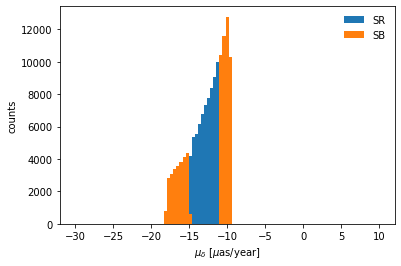

In [53]:
_,_,_=plt.hist(SR[:,0],bins=np.linspace(-30,10,100),label="SR")
_,_,_=plt.hist(SB[:,0],bins=np.linspace(-30,10,100),label="SB")
plt.legend(frameon=False)
plt.xlabel(r"$\mu_\delta$ [$\mu$as/year]")
plt.ylabel("counts")

In [16]:
X = np.concatenate([SR,SB,GD1])
Y = np.concatenate([np.ones(len(SR)),np.zeros(len(SB)),2.*np.ones(len(GD1))])
X_scaled = preprocessing.scale(X)
GD1_scaled = X_scaled[Y==2]
X_scaled = X_scaled[Y<2]
Y = Y[Y<2]
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.5)

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [17]:
model = Sequential()
model.add(Dense(64, input_dim=3, activation='relu')) 
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train[:,1:],Y_train, epochs=20, batch_size=200,validation_data=(X_test[:,1:],Y_test))

Train on 71263 samples, validate on 71264 samples
Epoch 1/20
71263/71263 [==============================] - 5s 75us/step - loss: 0.6938 - acc: 0.5033 - val_loss: 0.6933 - val_acc: 0.5047
Epoch 2/20
71263/71263 [==============================] - 3s 37us/step - loss: 0.6934 - acc: 0.5040 - val_loss: 0.6932 - val_acc: 0.5010
Epoch 3/20
71263/71263 [==============================] - 3s 37us/step - loss: 0.6933 - acc: 0.5021 - val_loss: 0.6931 - val_acc: 0.5013
Epoch 4/20
71263/71263 [==============================] - 3s 37us/step - loss: 0.6932 - acc: 0.5019 - val_loss: 0.6931 - val_acc: 0.5029
Epoch 5/20
71263/71263 [==============================] - 3s 37us/step - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6930 - val_acc: 0.5050
Epoch 6/20
71263/71263 [==============================] - 3s 37us/step - loss: 0.6930 - acc: 0.5053 - val_loss: 0.6931 - val_acc: 0.5057
Epoch 7/20
71263/71263 [==============================] - 3s 37us/step - loss: 0.6932 - acc: 0.5037 - val_loss: 0.6932 - val_acc

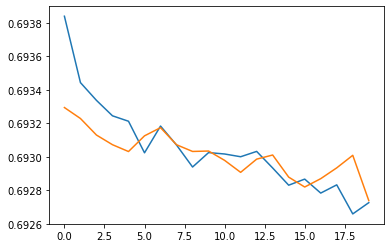

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [19]:
preds = model.predict(X_test[:,1:6], batch_size=int(0.1*len(X_test)))

Text(0.5, 0, 'NN')

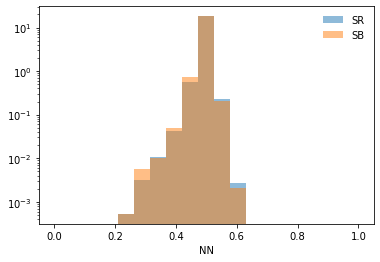

In [20]:
plt.hist(preds[Y_test==1],alpha=0.5,bins=np.linspace(0,1,20),label="SR",density=True)
plt.hist(preds[Y_test==0],alpha=0.5,bins=np.linspace(0,1,20),label="SB",density=True)
plt.legend(frameon=False)
plt.yscale("log")
plt.xlabel("NN")

In [31]:
preds_GD1 = model.predict(GD1_scaled[:,1:6], batch_size=int(0.1*len(GD1_scaled)))

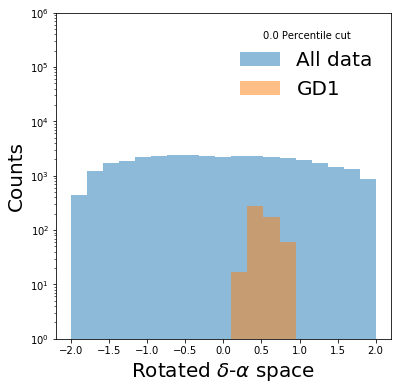

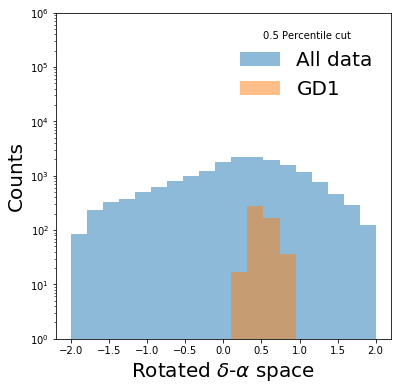

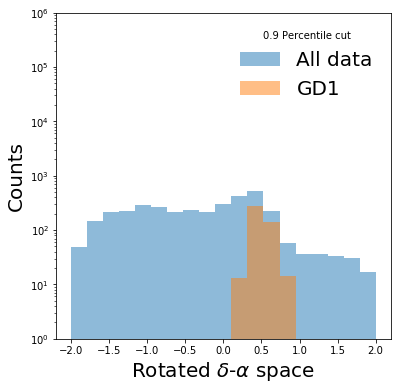

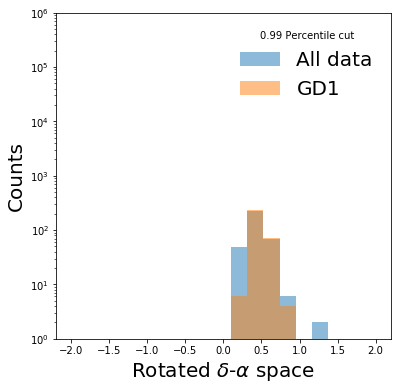

In [52]:
for cut in [0.,0.5,0.9,0.99]:
    X_pass = X_test[(Y_test==1)*(preds[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
    X_pass_GD1 = GD1_scaled[preds_GD1[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]

    plt.figure(figsize=(6,6))
    plt.hist(X_pass[:,1],label="All data",alpha=0.5,bins=np.linspace(-2,2,20))
    plt.hist(X_pass_GD1[:,1],label="GD1",alpha=0.5,bins=np.linspace(-2,2,20))
    plt.yscale("log")
    plt.legend(frameon=False,title=str(100*cut)+"th percentile cut",fontsize=20)
    plt.ylim([1,1e6])
    plt.ylabel("Counts",fontsize=20)
    plt.xlabel(r"Rotated $\delta$-$\alpha$ space",fontsize=20)

In [35]:
from sklearn.metrics import roc_curve, auc,roc_auc_score

In [43]:
fpr, tpr, thresholds = roc_curve(np.concatenate([np.zeros(len(preds)),np.ones(len(preds_GD1))]), np.concatenate([preds,preds_GD1]))

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Significance Improvement')

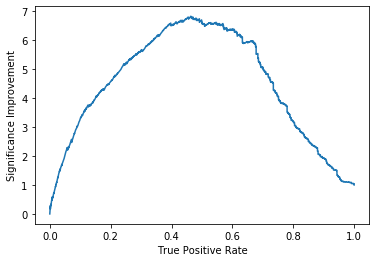

In [48]:
plt.plot(tpr,tpr/fpr**0.5)
plt.xlabel("True Positive Rate")
plt.ylabel("Significance Improvement")

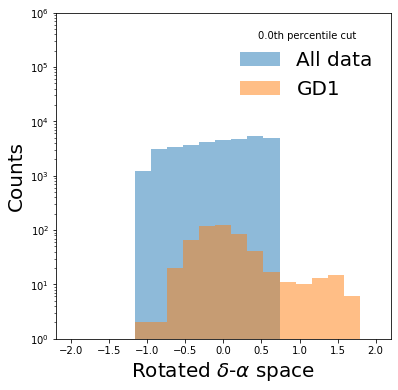

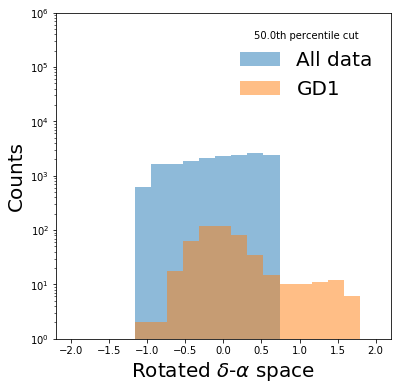

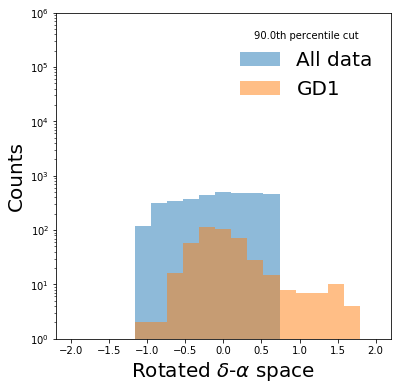

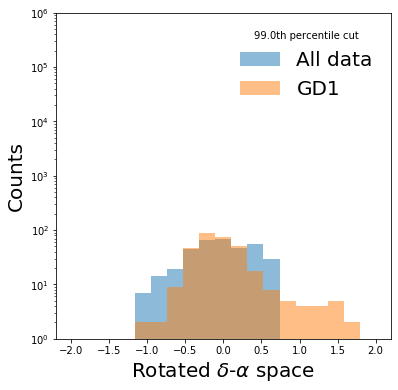

In [54]:
for cut in [0.,0.5,0.9,0.99]:
    X_pass = X_test[(Y_test==1)*(preds[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
    X_pass_GD1 = GD1_scaled[preds_GD1[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]

    plt.figure(figsize=(6,6))
    plt.hist(X_pass[:,0],label="All data",alpha=0.5,bins=np.linspace(-2,2,20))
    plt.hist(X_pass_GD1[:,0],label="GD1",alpha=0.5,bins=np.linspace(-2,2,20))
    plt.yscale("log")
    plt.legend(frameon=False,title=str(100*cut)+"th percentile cut",fontsize=20)
    plt.ylim([1,1e6])
    plt.ylabel("Counts",fontsize=20)
    plt.xlabel(r"Rotated $\delta$-$\alpha$ space",fontsize=20)

In [55]:
#Repeat with GD1 removed.